In [6]:
! pip install nltk tensorflow torch transformers

In [7]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import Adam

In [8]:
# Load dataset
df = pd.read_csv("Fake_News.csv", encoding="ISO-8859-1")
df.head()


,Headlines,Summary,Sources,Date,Fake/Real(1/0)
0,Bungalow with private island up for sale for ?...,"A bungalow with a private island, located off ...",Bloomberg,15-02-2017,0
1,Americans react to Bollywood song &# ;Pinga&# ;,A video by YouTube channel &# ;Fomo Daily&# ; ...,YouTube,02-08-2016,0
2,World Toilet Day is celebrated on November 19,The United Nations has designated November 19 ...,United Nations,19-11-2016,0
3,Over 1.57 lakh people affected by Assam floods,Over 1.57 lakh people reportedly have been aff...,Northeast Today,21-07-2016,0
4,Varun Gandhi unhurt after stage collapses,BJP MP Varun Gandhi on Sunday escaped unhurt a...,India Today,13-03-2016,0


In [9]:
# Data Exploration
print("Dataset Info:\n", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56386 entries, 0 to 56385
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Headlines       56386 non-null  object
 1   Summary         56386 non-null  object
 2   Sources         56386 non-null  object
 3   Date            56386 non-null  object
 4   Fake/Real(1/0)  56386 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.2+ MB
Dataset Info:
 None


In [10]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Headlines         0
Summary           0
Sources           0
Date              0
Fake/Real(1/0)    0
dtype: int64


In [11]:
print("Class Distribution:\n", df['Fake/Real(1/0)'].value_counts())

Class Distribution:
 Fake/Real(1/0)
0    35053
1    21333
Name: count, dtype: int64


In [12]:
# Check for duplicates
df = df.drop_duplicates()

In [13]:
# Download necessary NLTK data
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

In [14]:
# Data Cleaning Function
def clean_text(text):
    text = re.sub(r'<.*?>', '', str(text))  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters & numbers
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return " ".join(tokens)

# Apply text cleaning
df['Cleaned_Text'] = df['Headlines'].apply(clean_text) + " " + df['Summary'].apply(clean_text)

In [15]:
# Feature Extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Cleaned_Text'])
y = df['Fake/Real(1/0)']

<ipython-input-18-36b3ded8fd67>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Fake/Real(1/0)', data=df, palette='coolwarm')


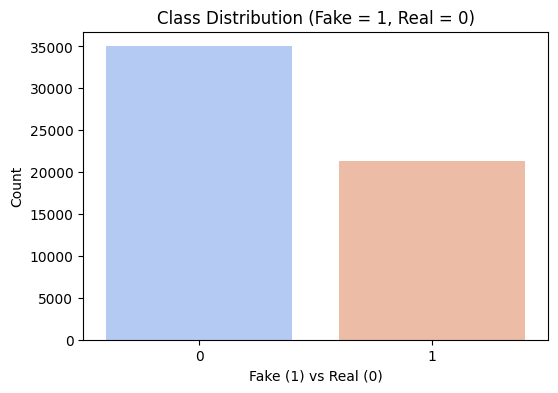

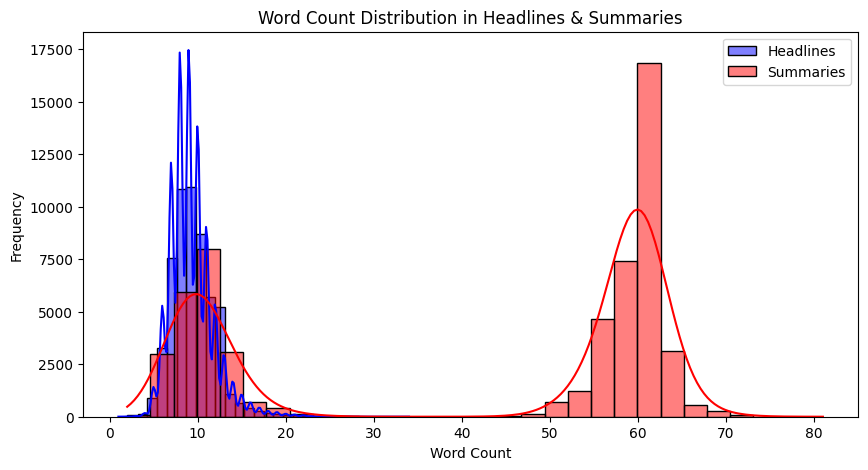

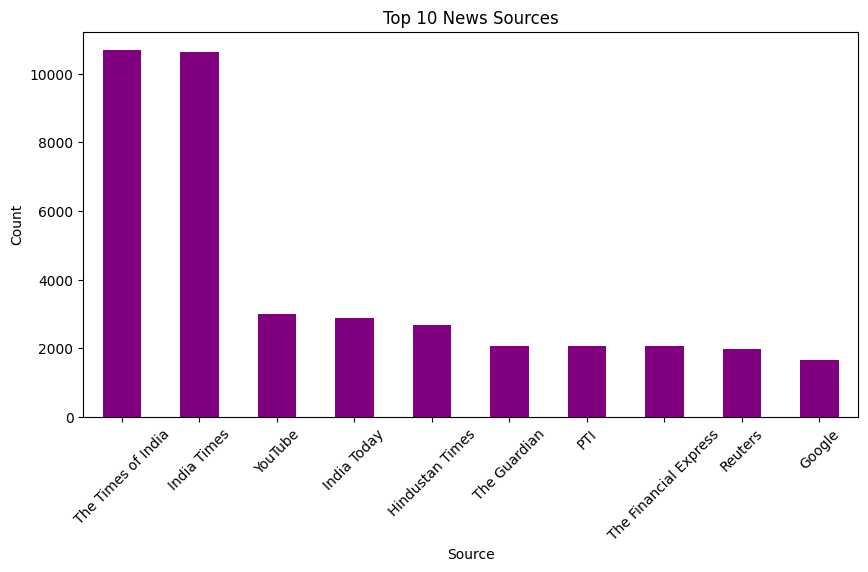

In [18]:
# Class Distribution (Fake vs Real)
plt.figure(figsize=(6, 4))
sns.countplot(x='Fake/Real(1/0)', data=df, palette='coolwarm')
plt.title('Class Distribution (Fake = 1, Real = 0)')
plt.xlabel('Fake (1) vs Real (0)')
plt.ylabel('Count')
plt.show()

# Word Distribution in Headlines & Summaries
df['Headline_Word_Count'] = df['Headlines'].apply(lambda x: len(str(x).split()))
df['Summary_Word_Count'] = df['Summary'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(df['Headline_Word_Count'], bins=30, kde=True, color='blue', label='Headlines')
sns.histplot(df['Summary_Word_Count'], bins=30, kde=True, color='red', label='Summaries')
plt.title('Word Count Distribution in Headlines & Summaries')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Top Sources
plt.figure(figsize=(10, 5))
df['Sources'].value_counts().nlargest(10).plot(kind='bar', color='purple')
plt.title('Top 10 News Sources')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [31]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Model Training & Evaluation Function
def train_and_evaluate(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

In [34]:
# Train Machine Learning Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Naïve Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    train_and_evaluate(model, name)


Logistic Regression Performance:
Accuracy: 0.9933
Precision: 0.9934
Recall: 0.9890
F1 Score: 0.9912
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6989
           1       0.99      0.99      0.99      4279

    accuracy                           0.99     11268
   macro avg       0.99      0.99      0.99     11268
weighted avg       0.99      0.99      0.99     11268


Naïve Bayes Performance:
Accuracy: 0.9609
Precision: 0.9805
Recall: 0.9152
F1 Score: 0.9467
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6989
           1       0.98      0.92      0.95      4279

    accuracy                           0.96     11268
   macro avg       0.97      0.95      0.96     11268
weighted avg       0.96      0.96      0.96     11268


Random Forest Performance:
Accuracy: 0.9964
Precision: 0.9960
Recall: 0.9944
F1 Score: 0.9952
              precision    recall  f1-score   support

  

In [35]:
# ======== Deep Learning: LSTM Model =========
# Tokenization & Padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Cleaned_Text'])
X_sequences = tokenizer.texts_to_sequences(df['Cleaned_Text'])
X_padded = pad_sequences(X_sequences, maxlen=100, padding="post")


In [36]:
# Splitting Data for LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [39]:
# Build LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/5
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 178s 122ms/step - accuracy: 0.6189 - loss: 0.6687 - val_accuracy: 0.6203 - val_loss: 0.6640
Epoch 2/5
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 210s 129ms/step - accuracy: 0.6156 - loss: 0.6673 - val_accuracy: 0.6203 - val_loss: 0.6641
Epoch 3/5
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 205s 130ms/step - accuracy: 0.6227 - loss: 0.6634 - val_accuracy: 0.6203 - val_loss: 0.6639
Epoch 4/5
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 189s 121ms/step - accuracy: 0.6200 - loss: 0.6642 - val_accuracy: 0.6203 - val_loss: 0.6640
Epoch 5/5
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 202s 122ms/step - accuracy: 0.6236 - loss: 0.6626 - val_accuracy: 0.6203 - val_loss: 0.6639


In [40]:
# Evaluate LSTM Model
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")
print("\nLSTM Performance:")
print(f"Accuracy: {accuracy_score(y_test_lstm, y_pred_lstm):.4f}")
print(f"Precision: {precision_score(y_test_lstm, y_pred_lstm):.4f}")
print(f"Recall: {recall_score(y_test_lstm, y_pred_lstm):.4f}")
print(f"F1 Score: {f1_score(y_test_lstm, y_pred_lstm):.4f}")
print(classification_report(y_test_lstm, y_pred_lstm))

353/353 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step

LSTM Performance:
Accuracy: 0.6203
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
              precision    recall  f1-score   support

           0       0.62      1.00      0.77      6989
           1       0.00      0.00      0.00      4279

    accuracy                           0.62     11268
   macro avg       0.31      0.50      0.38     11268
weighted avg       0.38      0.62      0.47     11268



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_